В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [41]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    f1_score)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

In [2]:
bank_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\bank-customer-churn-prediction-dlu-course-c-4\train.csv')
train_df, val_df = train_test_split(bank_df, test_size=0.2, random_state=42, stratify=bank_df['Exited'])
print(bank_df['Exited'].value_counts(normalize=True))
print(train_df['Exited'].value_counts(normalize=True))
print(val_df['Exited'].value_counts(normalize=True))

Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64
Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64
Exited
0.0    0.796667
1.0    0.203333
Name: proportion, dtype: float64


In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [4]:
input_cols = list(bank_df.columns)[1:-1]
target_col = 'Exited'
print(input_cols)
print(target_col)

['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Exited


In [5]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
print(train_inputs.shape, train_targets.shape)
print(val_inputs.shape, val_targets.shape)

(12000, 12) (12000,)
(3000, 12) (3000,)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [6]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
print(numeric_cols)
print(categorical_cols)

['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
['Surname', 'Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [7]:
cols_to_drop = ['CustomerId', 'Surname']
train_inputs = train_inputs.drop(columns=cols_to_drop)
val_inputs = val_inputs.drop(columns=cols_to_drop)

In [8]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

In [9]:
train_inputs[categorical_cols].nunique()

Geography    3
Gender       2
dtype: int64

Колонки CustomerId та Surname було вилучено, оскільки вони не несуть корисної інформації для прогнозування відтоку клієнтів: CustomerId є унікальним ідентифікатором, а Surname має велику кількість унікальних значень та не має зрозумілого способу кодування.

In [10]:
# scaler = MinMaxScaler().fit(train_inputs[numeric_cols])
# train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
# val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [11]:
scaler = StandardScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [12]:
train_inputs[numeric_cols].describe().round(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00000,12000.00000,12000.00000,12000.00000,12000.00000,12000.00000,12000.00000,12000.00000
mean,0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000
std,1.00004,1.00004,1.00004,1.00004,1.00004,1.00004,1.00004,1.00004
min,-3.14993,-2.41923,-1.80674,-0.71795,-1.10819,-1.94151,-0.98331,-2.58800
25%,-0.77200,-0.69892,-0.72832,-0.71795,-1.10819,0.51506,-0.98331,-0.76005
50%,0.02986,-0.08453,-0.00938,-0.71795,0.76930,0.51506,-0.98331,0.12331
75%,0.67964,0.52986,0.70957,1.11747,0.76930,0.51506,1.01698,0.85375
max,2.64281,4.46198,1.78798,2.78377,4.52430,0.51506,1.01698,1.79874


Для числових колонок було застосовано StandardScaler. Колонка Balance містить майже однакові значення для більшості клієнтів, але після масштабування StandardScaler вона зберегла мінімальні відмінності, що дозволяє моделі використовувати її для прогнозування. 

In [13]:
gender_codes = {'Male': 1, 'Female': 0}
train_inputs['gender_codes'] = train_inputs['Gender'].map(gender_codes)
val_inputs['gender_codes'] = val_inputs['Gender'].map(gender_codes)

In [14]:
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[['Geography']])
ohe = enc.get_feature_names_out(['Geography'])
print(ohe)
train_inputs[ohe] = enc.transform(train_inputs[['Geography']])
val_inputs[ohe] = enc.transform(val_inputs[['Geography']])

['Geography_France' 'Geography_Germany' 'Geography_Spain']


In [15]:
train_inputs.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,gender_codes,Geography_France,Geography_Germany,Geography_Spain
7180,0.320187,France,Male,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1,1.0,0.0,0.0
10393,0.347838,France,Female,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,0,1.0,0.0,0.0
80,0.638166,Germany,Male,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,1,0.0,1.0,0.0
3365,0.140460,Spain,Male,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,1,0.0,0.0,1.0
12236,0.665816,France,Male,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1,1.0,0.0,0.0


In [16]:
train_inputs = train_inputs.drop(columns=categorical_cols)
val_inputs = val_inputs.drop(columns=categorical_cols)

Категоріальні ознаки були закодовані для можливості використання в моделі. Ознаку Gender закодовано бінарно Male - 1, Female - 0. Ознаку Geography закодовано за допомогою One-Hot Encoding. Кодувальник навчено на тренувальних даних і застосовано до train та val наборів.

In [17]:
train_inputs.describe().round(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,gender_codes,Geography_France,Geography_Germany,Geography_Spain
count,12000.000,12000.000,12000.000,12000.000,12000.000,12000.000,12000.000,12000.000,12000.000,12000.000,12000.000,12000.000
mean,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.573,0.601,0.179,0.220
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.495,0.490,0.384,0.414
min,-3.150,-2.419,-1.807,-0.718,-1.108,-1.942,-0.983,-2.588,0.000,0.000,0.000,0.000
25%,-0.772,-0.699,-0.728,-0.718,-1.108,0.515,-0.983,-0.760,0.000,0.000,0.000,0.000
50%,0.030,-0.085,-0.009,-0.718,0.769,0.515,-0.983,0.123,1.000,1.000,0.000,0.000
75%,0.680,0.530,0.710,1.117,0.769,0.515,1.017,0.854,1.000,1.000,0.000,0.000
max,2.643,4.462,1.788,2.784,4.524,0.515,1.017,1.799,1.000,1.000,1.000,1.000


In [18]:
val_inputs.describe().round(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,gender_codes,Geography_France,Geography_Germany,Geography_Spain
count,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000
mean,0.007,0.032,-0.001,-0.023,0.006,-0.019,-0.019,-0.023,0.551,0.607,0.171,0.222
std,0.995,1.048,0.991,0.985,0.997,1.013,1.000,1.016,0.497,0.488,0.377,0.415
min,-3.108,-2.296,-1.807,-0.718,-1.108,-1.942,-0.983,-2.578,0.000,0.000,0.000,0.000
25%,-0.758,-0.699,-0.728,-0.718,-1.108,0.515,-0.983,-0.776,0.000,0.000,0.000,0.000
50%,0.058,-0.085,-0.009,-0.718,0.769,0.515,-0.983,0.109,1.000,1.000,0.000,0.000
75%,0.680,0.530,0.710,1.081,0.769,0.515,1.017,0.849,1.000,1.000,0.000,0.000
max,2.643,4.216,1.788,2.386,4.524,0.515,1.017,1.798,1.000,1.000,1.000,1.000


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [19]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 12)
train_targets: (12000,)
val_inputs: (3000, 12)
val_targets: (3000,)


In [20]:
train_inputs.to_parquet('train_inputs.parquet')
train_targets.to_frame().to_parquet('train_targets.parquet')
val_inputs.to_parquet('val_inputs.parquet')
val_targets.to_frame().to_parquet('val_targets.parquet')

In [21]:
os.listdir('.')

['HW_2_2_Логістична_регресія_з_scikit_learn.ipynb',
 'HW_2_2_Математичне_формулювання_логістичної_регресії.ipynb',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [22]:
X_train = train_inputs
y_train = train_targets
X_val = val_inputs
y_val = val_targets

In [23]:
model = LogisticRegression(solver='liblinear', random_state=42).fit(X_train, y_train)
train_probs = model.predict_proba(X_train)[:, 1]
val_probs = model.predict_proba(X_val)[:, 1]

In [39]:
model_train_preds = model.predict(X_train)
model_val_preds = model.predict(X_val)

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [25]:
train_preds = (train_probs >= 0.5).astype(int)
val_preds = (val_probs >= 0.5).astype(int)

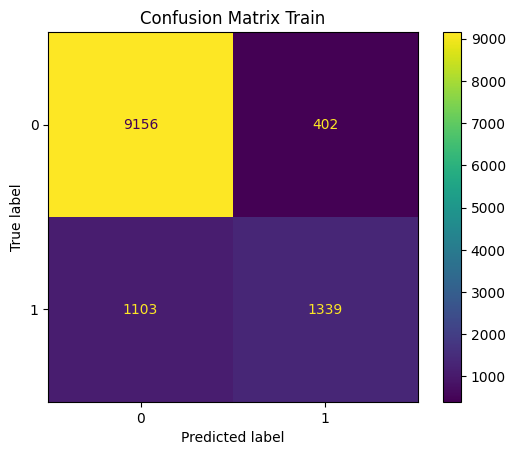

In [26]:
cm_train = confusion_matrix(y_train, train_preds)
ConfusionMatrixDisplay(cm_train).plot()
plt.title('Confusion Matrix Train')
plt.show()

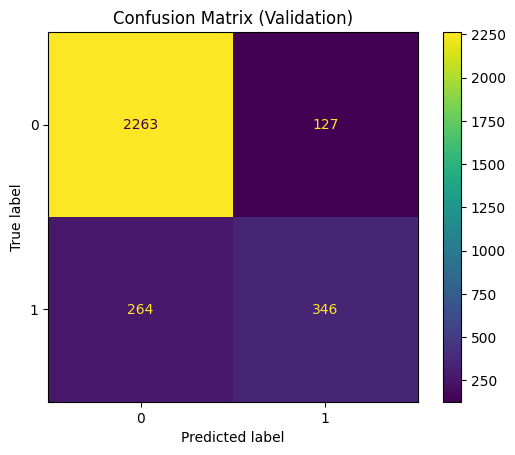

In [27]:
cm_val = confusion_matrix(y_val, val_preds)
ConfusionMatrixDisplay(cm_val).plot()
plt.title("Confusion Matrix (Validation)")
plt.show()

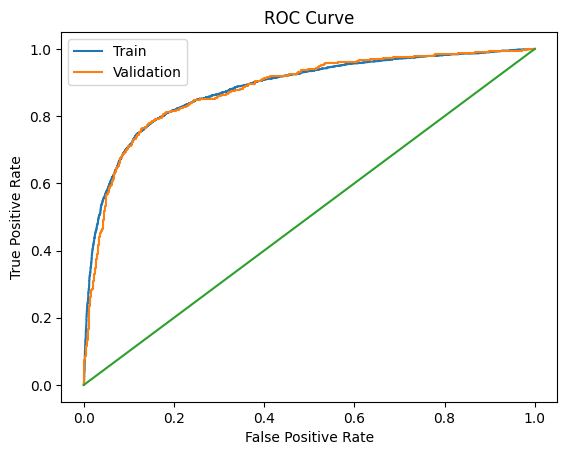

In [32]:
fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
plt.plot(fpr_train, tpr_train, label="Train")

fpr_val, tpr_val, _ = roc_curve(y_val, val_probs)
plt.plot(fpr_val, tpr_val, label="Validation")

plt.plot([0, 1], [0, 1], linestyle="-")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [33]:
auc_train = roc_auc_score(y_train, train_probs)
auc_val = roc_auc_score(y_val, val_probs)

print("ROC AUC (train):", round(auc_train, 4))
print("ROC AUC (val):", round(auc_val, 4))

ROC AUC (train): 0.8825
ROC AUC (val): 0.8797


In [34]:
f1_train = f1_score(y_train, train_preds)
f1_val = f1_score(y_val, val_preds)

print("F1 score (train):", round(f1_train, 4))
print("F1 score (val):", round(f1_val, 4))

F1 score (train): 0.6402
F1 score (val): 0.639


Значення ROC AUC на тренувальному та валідаційному наборах становить близько 0.88, що свідчить про хорошу здатність моделі розрізняти класи. Різниця між значеннями метрик на train та validation є мінімальною, що вказує на відсутність перенавчання. Значення F1-score при порозі 0.5 є на рівні 0.64, що є задовільним результатом для задачі. Модель можна вважати хорошою базовою моделлю для подальшого покращення.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [35]:
y_train.value_counts(normalize=True)

Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64

In [36]:
baseline_train_preds = np.zeros(len(y_train), dtype=int)
baseline_val_preds = np.zeros(len(y_val), dtype=int)

In [38]:
baseline_acc_train = accuracy_score(y_train, baseline_train_preds)
baseline_acc_val = accuracy_score(y_val, baseline_val_preds)

print("Baseline Accuracy (train):", round(baseline_acc_train, 4))
print("Baseline Accuracy (val):", round(baseline_acc_val, 4))

Baseline Accuracy (train): 0.7965
Baseline Accuracy (val): 0.7967


In [40]:
model_acc_train = accuracy_score(y_train, model_train_preds)
model_acc_val = accuracy_score(y_val, model_val_preds)

print("Model Accuracy (train):", round(model_acc_train, 4))
print("Model Accuracy (val):", round(model_acc_val, 4))

Model Accuracy (train): 0.8746
Model Accuracy (val): 0.8697


Для порівняння було побудовано baseline-модель, яка передбачає мажоритарний клас. Її accuracy становить близько 0.8, що відповідає частці мажоритарного класу в даних. Наша модель логістичної регресії показує вищу accuracy близько 0.87 як на тренувальних, так і на валідаційних даних, що свідчить про те, що модель навчається корисним закономірностям і має хорошу якість.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [43]:
joblib.dump(
    {   "model": model,
        "scaler": scaler,
        "encoder": enc,
        "input_columns": X_train.columns.tolist()},
    "log_reg.joblib")

['log_reg.joblib']

In [44]:
loaded_objects = joblib.load("log_reg.joblib")

In [45]:
model_2 = loaded_objects["model"]
scaler_2 = loaded_objects["scaler"]
encoder_2 = loaded_objects["encoder"]
input_columns_2 = loaded_objects["input_columns"]

In [46]:
print(model.coef_[0][:5])
print(model_2.coef_[0][:5])

[-0.15354896  1.29200026 -0.01912394 -0.32694862 -0.72195139]
[-0.15354896  1.29200026 -0.01912394 -0.32694862 -0.72195139]


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [49]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, input_df):
    df = input_df.copy()
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    gender_codes = {'Male': 1, 'Female': 0}
    df['gender_codes'] = df['Gender'].map(gender_codes)
    encoded = encoder.transform(df[['Geography']])
    encoded_cols = encoder.get_feature_names_out(['Geography'])
    encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
    X_input = pd.concat([df[numeric_cols + ['gender_codes']], encoded_df], axis=1)
    prob = model.predict_proba(X_input)[:, 1]

    return prob

In [50]:
predict_raw_df(scaler, enc, numeric_cols, bank_df[:5])

array([0.00563659, 0.03332141, 0.38094384, 0.38050085, 0.97925434])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [52]:
test_raw_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\bank-customer-churn-prediction-dlu-course-c-4\test.csv')
test_raw_df['Exited'] = predict_raw_df(scaler, enc, numeric_cols, test_raw_df)

In [53]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.069397
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.033316
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.153583
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.199176
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.054275


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [54]:
submission_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\bank-customer-churn-prediction-dlu-course-c-4\sample_submission.csv')
submission_df['Exited'] = predict_raw_df(scaler, enc, numeric_cols, test_raw_df)

In [58]:
submission_df.head()

,id,Exited
0,15000,0.069397
1,15001,0.033316
2,15002,0.153583
3,15003,0.199176
4,15004,0.054275


In [56]:
submission_df.to_csv('submission_log_reg.csv', index=False)